# Instability Analysis for Moving Barrier Cosntraint
It has been observed that moving barrier constraint has worse stability in general. In this notebook, we will see why it happens.

## Experiment details
In our algorithm, as a part of the Douglas-Rachford algorithm, we project our variables to the costraint space. To do this, we solve the following equation:
$\begin{align} U - U_0 + I^* (I(U)- V_0) + H^* \lambda = 0\end{align}$
where $U,V$ are the projected variables to be found, $U_0, V_0$ are the original variables, $I$ is the interpolation operator, $H$ represents the operator defining the affine constraint $HU = F$ and $\lambda$ is a Largrange multiplier to be found.

In this experiment, we will plot the norm of the LHS of (1) and $\lambda$. When we calculate $\lambda$, we find $HU'- F = H(\textrm{Id}+  I^* I)^{-1}(U + I^* V) - F$ and solve a certain linear equation with $HU'-F$ as the right hand side. We call this vector a `pre_lambda` vector. We will also plot the norm of  this vector as well as the norm of $U' = (\textrm{Id}+  I^* I)^{-1}(U + I^* V)$.

In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('../../..')
from proximal.dynamicUOT import computeGeodesic
from proximal.grids import speed_and_growth
import ipywidgets as widgets
from ipywidgets import interact
from collections import defaultdict
from PIL import Image

## Plotting function

In [2]:
def plot_log(log):
    # Plot 'pre_lambda', 'lambda', and 'first_order_condition' using subplots with different colors
    fig, axs = plt.subplots(6, 1, figsize=(10, 18))
    
    axs[0].plot(log['U_prime_interp'], label='U_prime_interp', color='blue')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Value')
    axs[0].set_title('Plot of U_prime_interp')
    axs[0].legend()

    # Plot 'pre_lambda'
    axs[1].plot(log['pre_lambda'], label='pre_lambda', color='blue')
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Value')
    axs[1].set_title('Plot of pre_lambda')
    axs[1].legend()
    
    # Plot 'lambda'
    axs[2].semilogy(log['lambda'], label='lambda', color='green')
    axs[2].set_xlabel('Iteration')
    axs[2].set_ylabel('Value')
    axs[2].set_title('Plot of lambda')
    axs[2].legend()
    
    # Plot 'first_order_condition'
    axs[3].semilogy(log['first_order_condition'], label='first_order_condition', color='red')
    axs[3].set_xlabel('Iteration')
    axs[3].set_ylabel('Value')
    axs[3].set_title('Plot of first_order_condition')
    axs[3].legend()

    # Plot 'HQHlambda'
    axs[4].plot(log['HQHlambda'], label='HQHlambda', color='red')
    axs[4].set_xlabel('Iteration')
    axs[4].set_ylabel('Value')
    axs[4].set_title('Plot of HQHlambda')
    axs[4].legend()

    # Plot 'lambda_eqn'
    axs[5].plot(log['lambda_eqn'], label='lambda_eqn', color='red')
    axs[5].set_xlabel('Iteration')
    axs[5].set_ylabel('Value')
    axs[5].set_title('Plot of lambda_eqn')
    axs[5].legend()
    
    plt.show()

# Unconstrained case
In the unconstrained case, we do not calculate the quantities mentioned above, but we still calculate $U' = (\textrm{Id}+  I^* I)^{-1}(U + I^* V)$. We will plot the norm of this quantity here.

## Set up

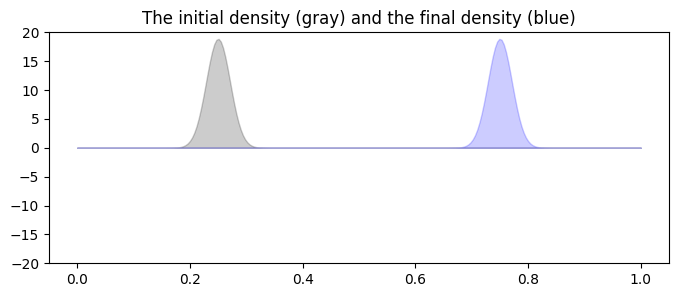

In [3]:
# Plotting initial and the final density
sigma = 0.03
K = 256
X = np.linspace(0, 1, K)  # Discretization of the time-space domain

def gauss(x, x_0, sigma, mass):
    # Gaussian bump
    normalized_factor = np.exp(-((x - x_0) ** 2) / sigma ** 2)
    return mass * (normalized_factor * K / np.sum(normalized_factor))

rho_0 = gauss(X, 0.25, sigma, 1) # Initial density
rho_1 = gauss(X, 0.75, sigma, 1)  # Final density

# Normalizing densities
rho_0 /= np.sum(rho_0) / 256 # make sure the total mass is 1
rho_1 /= np.sum(rho_1) / 256

rho_0.dtype = np.float64
rho_1.dtype = np.float64

# Plotting
plt.figure(figsize=(8, 3))
plt.ylim(-20, 20)
plt.title("The initial density (gray) and the final density (blue)")
plt.fill_between(X, rho_0, color="k", alpha=0.2)  # Use fill_between for similar effect to fill in Julia
plt.fill_between(X, rho_1, color="b", alpha=0.2)
plt.show()

## Calculation

In [4]:
T = 15 # number of time steps
ll = (1.0, 1.0) # size of time x space box
H = np.ones((T,K))
delta = 0.5/np.pi
log = defaultdict(list)
x, lists = computeGeodesic(rho_0, rho_1, T, ll, p= 2.0, q=2.0, delta=delta, niter=3000, log=log)

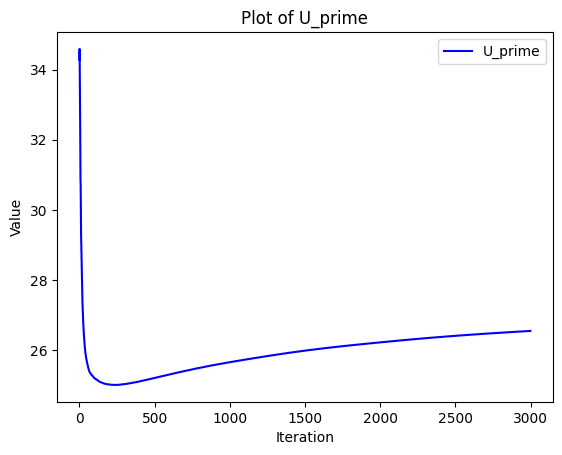

In [5]:
plt.plot(log['U_prime_interp'], label='U_prime', color='blue')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Plot of U_prime')
plt.legend()
plt.show()

# Total mass constraint
We will first see the plot for total mass constraint, which is known to be stable for comparison.

## Set up

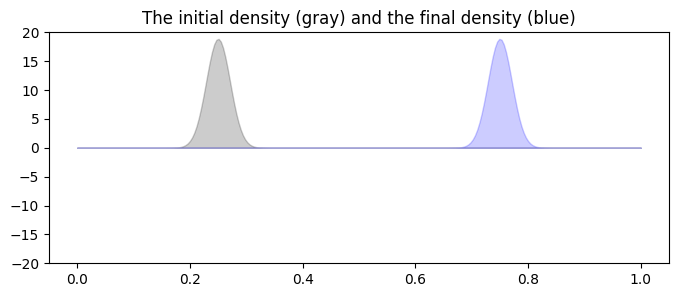

In [6]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('../../..')
from proximal.dynamicUOT import computeGeodesic
from proximal.grids import speed_and_growth
import ipywidgets as widgets
from ipywidgets import interact
from collections import defaultdict
from PIL import Image

# Plotting initial and the final density
sigma = 0.03
K = 256
X = np.linspace(0, 1, K)  # Discretization of the time-space domain

def gauss(x, x_0, sigma, mass):
    # Gaussian bump
    normalized_factor = np.exp(-((x - x_0) ** 2) / sigma ** 2)
    return mass * (normalized_factor * K / np.sum(normalized_factor))

rho_0 = gauss(X, 0.25, sigma, 1) # Initial density
rho_1 = gauss(X, 0.75, sigma, 1)  # Final density

# Normalizing densities
rho_0 /= np.sum(rho_0) / 256 # make sure the total mass is 1
rho_1 /= np.sum(rho_1) / 256

rho_0.dtype = np.float64
rho_1.dtype = np.float64

# Plotting
plt.figure(figsize=(8, 3))
plt.ylim(-20, 20)
plt.title("The initial density (gray) and the final density (blue)")
plt.fill_between(X, rho_0, color="k", alpha=0.2)  # Use fill_between for similar effect to fill in Julia
plt.fill_between(X, rho_1, color="b", alpha=0.2)
plt.show()

## Calculation

In [ ]:
T = 15 # number of time steps
ll = (1.0, 1.0) # size of time x space box
H = np.ones((T,K))
time = np.array([(i+0.5)/T for i in range(0,T)])
F = np.ones(T)
log = defaultdict(list)
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p= 2.0, q=2.0, delta=0.5/np.pi, niter=3000, log=log)
plot_log(log)

0 inf
1 13.67159024830549
2 1.1026193218287736
3 0.8342577859880319
4 0.6459956936974155
5 0.5070063981693672
6 0.40176175356619936
7 0.32117963203424765
8 0.25721516143420253
9 0.20648374136566733
10 0.16634429935574208
11 0.13488707180157214
12 0.10966738340174247
13 0.08920196659461872
14 0.07255767605201069
15 0.058935848666628106
16 0.04785019529399714
17 0.03899143268533662
18 0.03182673404238442
19 0.026000275809885467
20 0.021247151034554386
21 0.01736716445739618
22 0.01419910879027553
23 0.011611721490834184
0 inf
1 18.06221989109506
2 0.876099598388
3 0.6501457824670643
4 0.5000548282002123
5 0.3923772165714635
6 0.3113714697309125
7 0.2493518011736271
8 0.20057227231995822
9 0.16203748140773466
10 0.13114472189891338
11 0.10652489946493603
12 0.08695504673716005
13 0.07103578989723484
14 0.058001023956078986
15 0.047303203273561883
16 0.03862432058722062
17 0.03167414033003397
18 0.025972747644025306
19 0.0213271956966426
20 0.017518574738941233
21 0.014391963238855329
22 0

# Stationary Barrier Constraint
For another reference, we will plot the same graph for stationary barrier constraint.

## Set up

In [2]:
def image_to_numpy(image_path):
    # Load the image file
    image = Image.open(image_path).convert('L')  # Convert image to grayscale if it's not

    # Convert the PIL image to a numpy array
    image_array = np.array(image)

    return image_array

maze = (1-image_to_numpy('data/input/maze.png').squeeze()/255)

T = 60
N1 = maze.shape[0]
N2 = maze.shape[1]

H = np.repeat(maze[np.newaxis, :, :], T, axis=0)
F = np.zeros((T,))

dx = [1./N1, 1./N2]

indices = np.arange(0, 30) * 1./30
xx, yy = np.meshgrid(indices, indices)

rho_0 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[5./30., 5./30.], cov=2./36**2)
rho_1 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[24./30., 24./30.], cov=2./36**2)

plt.figure(figsize=(5, 5))
plt.imshow(maze)
plt.imshow(rho_0, alpha=0.5)
plt.imshow(rho_1, alpha=0.5)
plt.show()  

NameError: name 'Image' is not defined

## Calculation

In [ ]:
ll=(1.0, 1.0, 1.0)
log = defaultdict(list)
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p= 2.0, q=2.0, delta=1.0, niter=7000, log=log)

KeyboardInterrupt: 

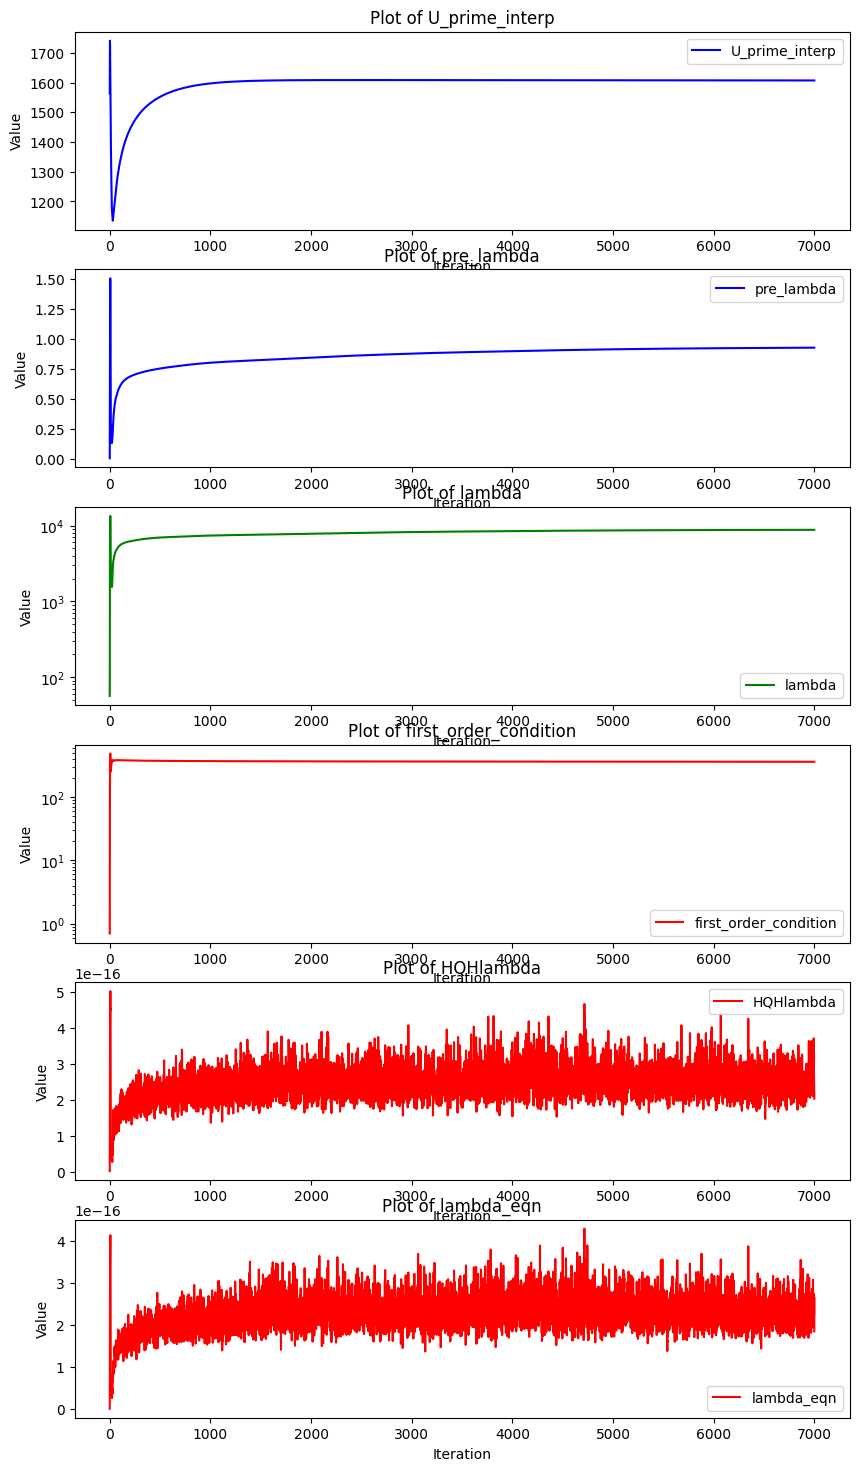

In [ ]:
plot_log(log)

## One Stationary One Moving
We will now consider a moving barrier constraint. 

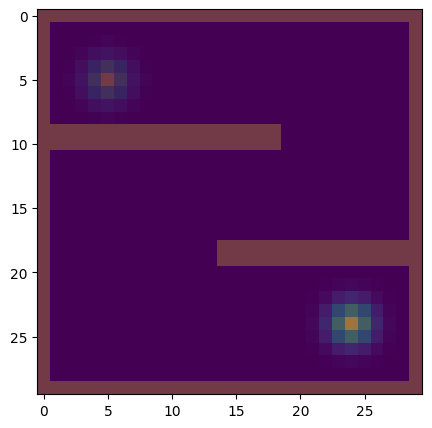

In [7]:
def image_to_numpy(image_path):
    # Load the image file
    image = Image.open(image_path).convert('L')  # Convert image to grayscale if it's not

    # Convert the PIL image to a numpy array
    image_array = np.array(image)

    return image_array

maze = (1-image_to_numpy('data/input/maze.png').squeeze()/255)

T = 30
N1 = maze.shape[0]
N2 = maze.shape[1]

H = np.repeat(maze[np.newaxis, :, :], T, axis=0)
F = np.zeros((T,))

dx = [1./N1, 1./N2]

indices = np.arange(0, 30) * 1./30
xx, yy = np.meshgrid(indices, indices)

rho_0 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[5./30., 5./30.], cov=2./36**2)
rho_1 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[24./30., 24./30.], cov=2./36**2)

plt.figure(figsize=(5, 5))
plt.imshow(maze)
plt.imshow(rho_0, alpha=0.5)
plt.imshow(rho_1, alpha=0.5)
plt.show()

def fill_region(frames, fps, speed, original, Hstep):
    rows, cols = 30, 30
    step_size = speed*14/fps

    # Define the region to fill
    start_col, end_col = 1, 14

    # Create a list to store each frame
    filled_frames = [original]

    for i in range(1,frames):
        frame = filled_frames[-1].copy()
        # Determine the slice to fill based on speed
        end_fill = max(1, int(end_col - i*step_size))
        frame[18:20, end_fill:14] += Hstep
        # if above 1, clip to 1
        frame[frame > 1] = 1
        
        # Append the current state of the array to the list
        filled_frames.append(frame.copy())
    
    return filled_frames

def plot_frames(frames):
    fig, axes = plt.subplots(1, len(frames), figsize=(15, 5))
    for idx, frame in enumerate(frames):
        ax = axes[idx]
        ax.imshow(frame, cmap='viridis', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f'Frame {idx + 1}')
    plt.tight_layout()
    plt.show()

In [9]:
frames = fill_region(T, 30, 1.0, maze, Hstep=1.0)
H = np.stack(frames, axis=0)

### Unstable case
As observed in One Stationary One Moving experiment, if the "step size" of the wall is too large, the solution diverges. We will see what happens when the divergence happens.

In [10]:
frames = fill_region(T, 30, 1.0, maze, Hstep=1.0)
H = np.stack(frames, axis=0)
ll=(1.0, 1.0, 1.0)
log = defaultdict(list)
rho_0[H[0] > 0] = 0
rho_1[H[-1] > 0] = 0
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p= 2.0, q=2.0, delta=1.0, niter=3000, log=log, init = 'fisher-rao')

1 547.1188191605925
2 1.6666339527975667e-14
1 292.3008550332578
2 9.334860497611597
3 3.1203798972725543
4 1.5322837381193999
5 0.8705957523860355
6 0.6001553769921181
7 0.4506641072464219
8 0.335002661963202
9 0.2627692128879356
10 0.2105372644253497
11 0.16923220162276156
12 0.13679164577656885
13 0.11577064835899378
14 0.10154300606619696
15 0.09899415742916681
16 0.10306675703847155
17 0.12184063709670978
18 0.13096226555555543
19 0.15425999795272413
20 0.18073782665639976
21 0.21393189442563673
22 0.23408476608060677
23 0.2594917134267187
24 0.28505051793181957
25 0.3099414125503122
26 0.33942591400241934
27 0.3724423150894045
28 0.4289583659557379
29 0.46993540321882415
30 0.4708033072211058
31 0.5059706386601568
32 0.5469640212421798
33 0.600055505434729
34 0.66109863451374
35 0.7155446416627891
36 0.7886133751326408
37 0.8675678487513526
38 0.9664609701547829
39 1.0604431129686465
40 1.173454644767063
41 1.2959158552980323
42 1.4369001493198048
43 1.5768776251365768
44 1.74043

KeyboardInterrupt: 

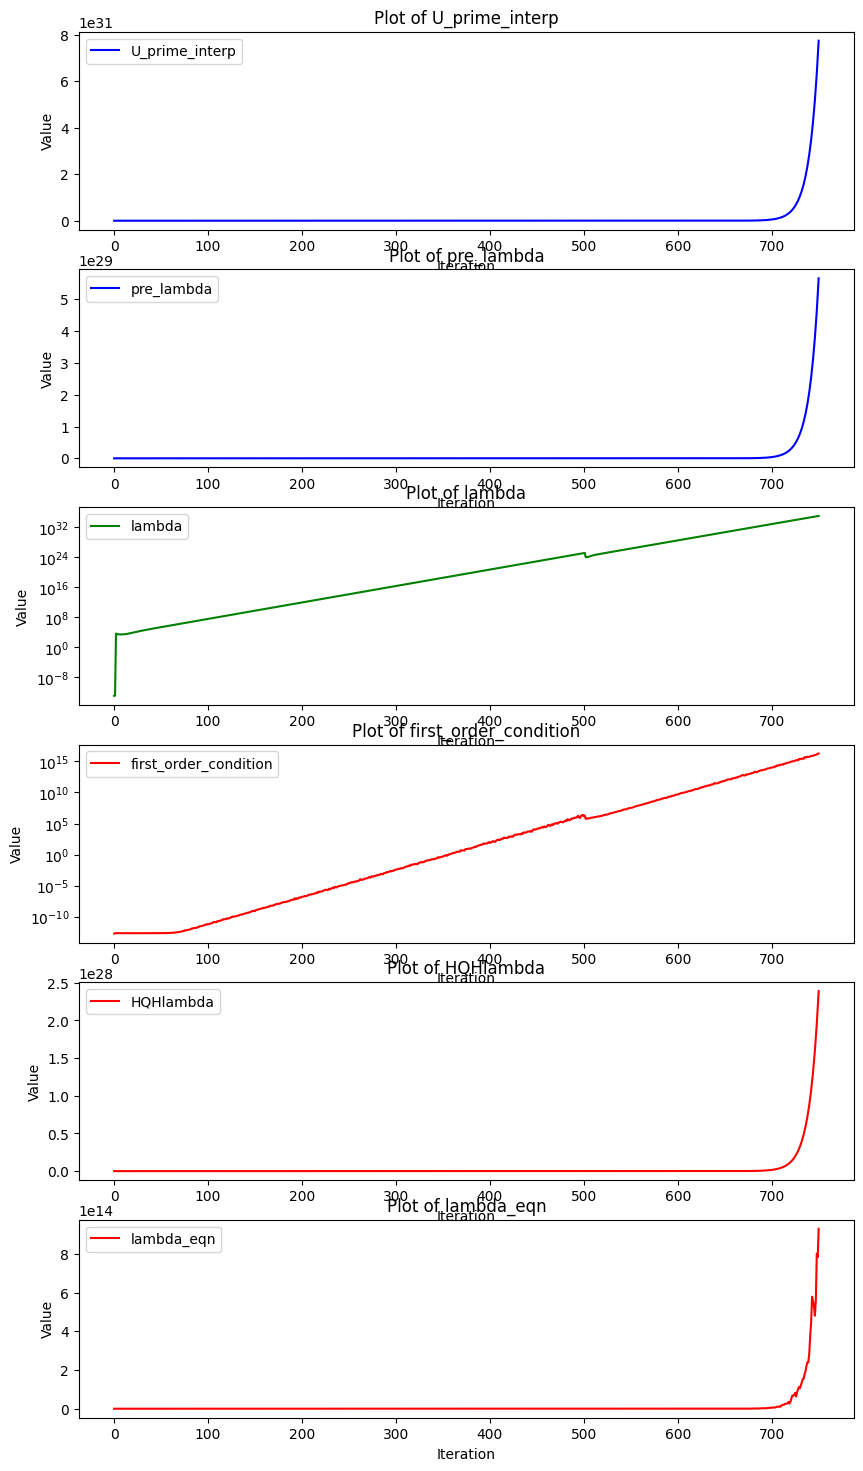

In [11]:
plot_log(log)

### Stable Case
It has been observed that the solution is relatively stable when `Hstep` is small. We will see what happens in this case.

In [14]:
frames = fill_region(T, 30, 1.0, maze, Hstep=0.05)
H = np.stack(frames, axis=0)
ll=(1.0, 1.0, 1.0)
log = defaultdict(list)
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p= 2.0, q=2.0, delta=10.0, niter=3000, log=log)

0 inf
1 52553.7213026748
2 8.729461614535648
3 5.524783451470364
4 5.035636586296662
5 4.816161765787085
6 4.641708456284898
7 4.48620661497495
8 4.344429514820383
9 4.219125207188507
10 4.097228655293038
11 3.9722951515193463
12 3.8607916817362797
13 3.7542963181414635
14 3.6510514864403816
15 3.549963252865384
16 3.4509894090985678
17 3.35234818287278
18 3.232665137450001
19 2.8134875191883006
20 2.4216249768523648
21 2.363232323167923
22 2.324337902494269
23 2.286152789259435
24 2.248601683178598
25 2.211672594194592
26 2.1753551472337254
27 2.1396386036129256
28 2.1045127906937164
29 2.0699676225717782
30 2.0359921284047737
31 2.002528078550966
32 1.9695938999509508
33 1.9372784616996017
34 1.9055069769319837
35 1.8742591781351052
36 1.8435076998127486
37 1.813231880465672
38 1.783424109422718
39 1.7540553850515672
40 1.7252980189581442
41 1.697032850961449
42 1.669232477241887
43 1.6418887820063408
44 1.61499419743165
45 1.588541336912439
46 1.5625228323089824
47 1.536931493195006

KeyboardInterrupt: 

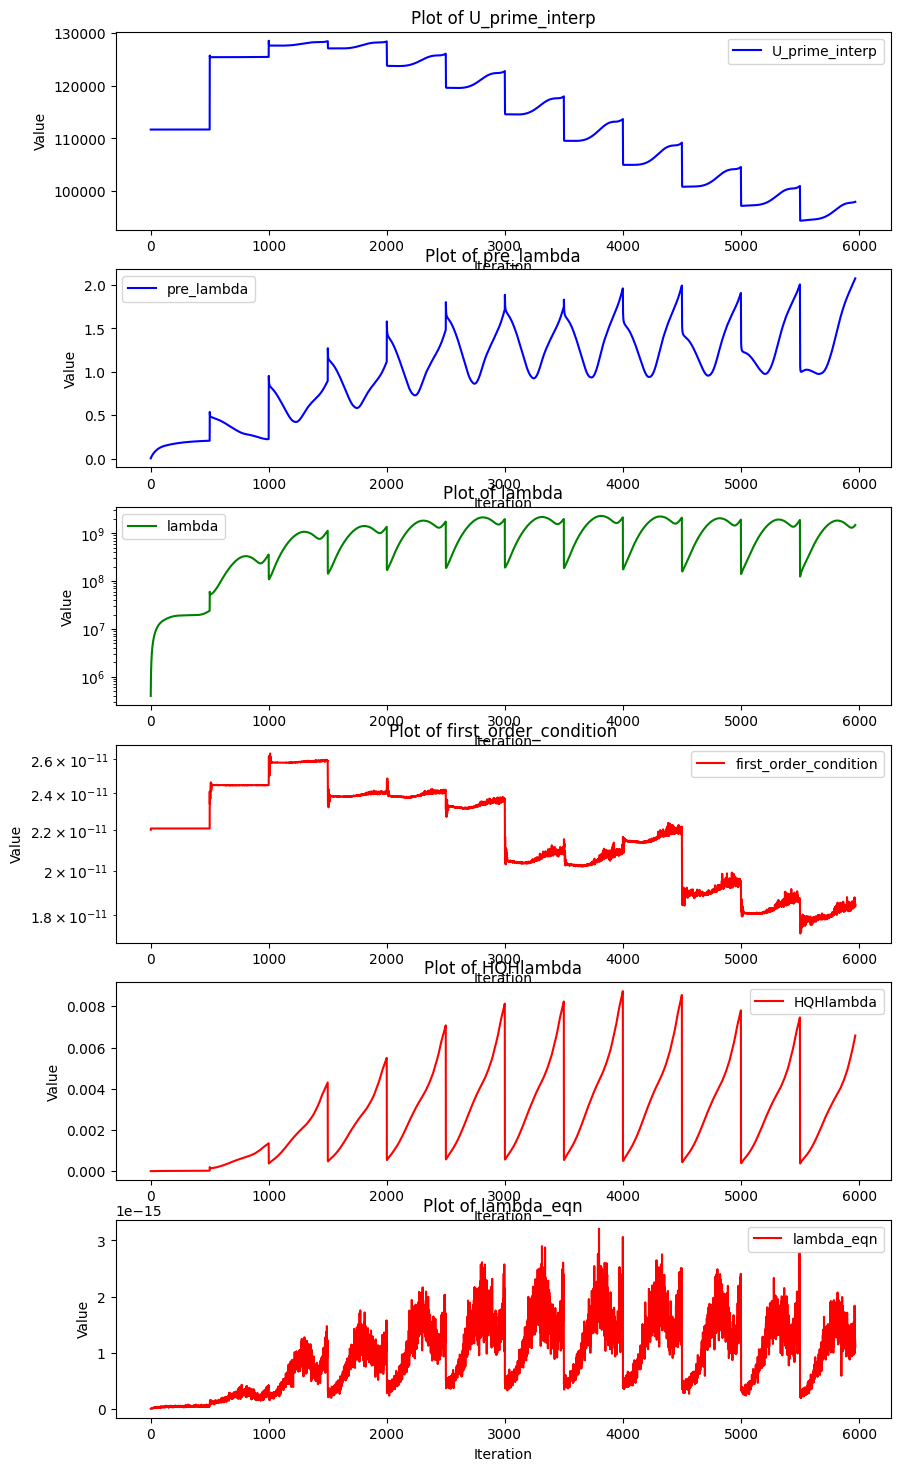

In [15]:
plot_log(log)